In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu

import sys
sys.path.append(os.path.dirname(os.path.abspath('')))

from caption_lda_model_train import mark_captions, create_tokenizer
from evaluation.caption_category_model_eval import generate_predictions, beam_search_predictions
from models.caption_lda_model import create_model
from dataset.utils import print_progress_bar, load_image

In [2]:
def load_data(data_type, data_dir):
    # Path for the cache-file.
    feature_cache_path = os.path.join(
        data_dir, 'feature_transfer_values_{}.pkl'.format(data_type)
    )
    topics_cache_path = os.path.join(
        data_dir, 'topics16_{}.pkl'.format(data_type)
    )
    captions_cache_path = os.path.join(
        data_dir, 'captions_{}.pkl'.format(data_type)
    )

    feature_path_exists = os.path.exists(feature_cache_path)
    topic_path_exists = os.path.exists(topics_cache_path)
    caption_path_exists = os.path.exists(captions_cache_path)
    if feature_path_exists and topic_path_exists and caption_path_exists:
        with open(feature_cache_path, mode='rb') as file:
            feature_obj = pickle.load(file)
        with open(topics_cache_path, mode='rb') as file:
            topics = pickle.load(file)
        with open(captions_cache_path, mode='rb') as file:
            captions = pickle.load(file)
    else:
        sys.exit('processed {} data does not exist.'.format(data_type))

    print('{} data loaded from cache-file.'.format(data_type))
    return feature_obj, topics, captions

In [3]:
data_dir = os.path.join(os.path.dirname(os.path.abspath('')), 'dataset', 'processed_lda_data')

In [4]:
# Load pre-processed data
features_train, topics_train, captions_train = load_data(
    'train', data_dir
)

train data loaded from cache-file.


In [5]:
# Load test data
with open(data_dir + '/feature_transfer_values_test.pkl', mode='rb') as file:
    features_test = pickle.load(file)
with open(data_dir + '/captions_test.pkl', mode='rb') as file:
    captions_test = pickle.load(file)
with open(data_dir + '/images_test.pkl', mode='rb') as file:
    images_test = pickle.load(file)

In [6]:
def load_test_topics(features_train, topics_train, features_test):
    topics_test = []
    print_progress_bar(0, len(features_test))
    for idx, feature in enumerate(features_test):
        topic_idx = np.argmax(np.sum(np.abs(features_train - feature), axis=1))
        topics_test.append(topics_train[topic_idx])
        print_progress_bar(idx + 1, len(features_test))
    return np.array(topics_test).astype(topics_train.dtype)

In [ ]:
topics_test = load_test_topics(features_train, topics_train, features_test)

In [7]:
# create tokenizer
mark_start = 'startseq'
mark_end = 'endseq'
captions_train_marked = mark_captions(captions_train, mark_start, mark_end)
tokenizer, vocab_size = create_tokenizer(captions_train_marked)

# Get data size
max_tokens = 16

In [13]:
# Embedding vector file
glove_path = os.path.join(os.path.dirname(os.path.abspath('')), 'dataset', 'glove.6B.300d.txt')

# Create Model
model = create_model(
    topics_test.shape[1:],
    features_test.shape[1:],
    tokenizer.word_index,
    glove_path,
    mark_start,
    mark_end,
    vocab_size,
    max_tokens
)

Creating word to vec map...
Done!
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
caption_input (InputLayer)      (None, 16)           0                                            
__________________________________________________________________________________________________
topic_input (InputLayer)        (None, 16)           0                                            
__________________________________________________________________________________________________
feature_input (InputLayer)      (None, 4096)         0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, 16, 300)      2593500     caption_input[0][0]              
___________________________________________________________________________

In [15]:
# Weights path
weights_path = os.path.join(os.path.dirname(os.path.abspath('')), 'weights', 'cplda-weights-04-2.59-b128-t16.hdf5')

# Load weights
try:
    model.load_weights(weights_path)
    print('Weights loaded.')
except Exception as e:
    print('Error loading the weights.')
    print(e)

Weights loaded.


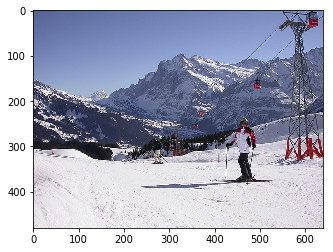

a man is playing tennis on a tennis court
A man in skies on a snowy slope
a person on skis in the snow at a ski slope
A person is standing at the top of a ski slope.
A person that is skiing in the snow.
man with skis standing on a skiing slope


In [29]:
idx = 30

y_pred = generate_predictions(
    topics_test[idx],
    features_test[idx],
    model,
    tokenizer,
    mark_start,
    mark_end,
    max_tokens
)

# Display image
img_path = os.path.join(os.path.dirname(os.path.abspath('')), 'dataset', images_test[idx])
img = load_image(img_path)
plt.imshow(img)
plt.show()

# Pred caption
print(y_pred, end='\n')

# original caption
for cap in captions_test[idx]:
    print(cap)

In [30]:
topics_test[0] - topics_test[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [33]:
t = []
for idx, feature in enumerate(features_test[:3]):
    topic_idx = np.argmax(np.sum(np.abs(features_train - feature), axis=1))
    print(topic_idx)
    t.append(topics_train[topic_idx])

14117
14117
14117


In [32]:
t[0] - t[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [41]:
np.sum(np.abs(features_train - features_test[10]), axis=1)

array([483.18356, 405.64334, 429.10986, ..., 407.93085, 466.80392,
       356.26105], dtype=float32)

In [40]:
np.abs(features_train - features_test[1340])

array([[0.18868303, 0.06688455, 0.33340037, ..., 0.        , 0.04027042,
        0.32450277],
       [0.00218701, 0.08325878, 0.11767995, ..., 0.        , 0.07133681,
        0.48712808],
       [0.21404672, 0.09442434, 0.28771204, ..., 0.        , 0.0213474 ,
        0.15571356],
       ...,
       [0.16636768, 0.08423662, 0.00491655, ..., 0.        , 0.18878174,
        0.00312984],
       [0.15363836, 0.02025664, 0.08556569, ..., 0.41076893, 0.25115424,
        0.18065357],
       [0.05533564, 0.02025664, 0.20493788, ..., 0.04322165, 0.28390408,
        0.0457356 ]], dtype=float32)